In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [306]:
sub = pd.read_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/subs_data.csv')
print(sub.columns)
sub.describe(include='all')

Index(['RECENCY', 'SUB_START', 'SUB_END', 'FREQUENCY', 'CURRENT_TERM',
       'MONETARY', 'REVENUE', 'RESUBSCRIBER', 'BRAND', 'Capstone_id'],
      dtype='object')


,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id
count,111668.000000,111668,111668,111668.000000,111668,111668.000000,111668.000000,111668.000000,111668,111668
unique,NaN,294,277,NaN,3,NaN,NaN,NaN,5,100000
top,NaN,2024-02-01,2024-11-01,NaN,monthly,NaN,NaN,NaN,PULSE,WFU2759137
freq,NaN,58654,43851,NaN,79219,NaN,NaN,NaN,50096,5
mean,118.185237,NaN,NaN,1.049002,NaN,29.065445,108.628462,0.040710,NaN,NaN
std,97.431236,NaN,NaN,0.267389,NaN,31.965700,31.421156,0.197618,NaN,NaN
min,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN
25%,32.000000,NaN,NaN,1.000000,NaN,8.990000,86.880000,0.000000,NaN,NaN
50%,90.000000,NaN,NaN,1.000000,NaN,11.990000,107.880000,0.000000,NaN,NaN
75%,214.000000,NaN,NaN,1.000000,NaN,62.990000,131.880000,0.000000,NaN,NaN


# Data Preprocessing
## Filter
Filter `sub_start` in second half year

In [307]:
sub.head()

,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id
0,7,2024-02-27,2024-03-05,1,monthly,11.99,143.88,0,PULSE,ETM3560501
1,61,2024-09-01,2024-11-01,1,monthly,11.99,143.88,0,PULSE,PJW3033219
2,7,2024-11-01,2024-11-08,1,monthly,7.99,95.88,0,PULSE,DPZ5855080
3,32,2024-02-01,2024-03-04,1,monthly,11.99,143.88,0,PULSE,ZLE5622372
4,137,2024-05-17,2024-10-01,1,monthly,11.99,143.88,0,PULSE,RAJ3140438


In [308]:
print(f'Sub data size: {sub.shape[0]}')
sub_filtered = sub[sub['SUB_START']<='2024-06-30']
print(f'Filtered sub data size: {sub_filtered.shape[0]}, ({100*sub_filtered.shape[0]/sub.shape[0]} %)')

# save df where sub_start in second half year 
sub_rest = sub[sub['SUB_START']>'2024-06-30']

Sub data size: 111668
Filtered sub data size: 96601, (86.50732528566823 %)


In [309]:
sub_filtered.head()

,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id
0,7,2024-02-27,2024-03-05,1,monthly,11.99,143.88,0,PULSE,ETM3560501
3,32,2024-02-01,2024-03-04,1,monthly,11.99,143.88,0,PULSE,ZLE5622372
4,137,2024-05-17,2024-10-01,1,monthly,11.99,143.88,0,PULSE,RAJ3140438
5,32,2024-02-01,2024-03-04,1,annual,86.88,86.88,0,PULSE,PPZ7199683
6,106,2024-02-01,2024-05-17,1,monthly,11.99,143.88,0,PULSE,PAO4909132


## Recalc
Split data into first half year and second half year:
- first half year data for feature engineering
- second half year data for LTV ground truth generation

Recalculate `recency` and `revenue`:
- recency: min(`sub_end`, 2024-06-30) - `sub_start` using first half year
- monetary 1: first half year 
- monetary 2: second half year with each term (monthly, weekly, annual)

In [310]:
# Recalc recency
sub_filtered['SUB_START'] = pd.to_datetime(sub_filtered['SUB_START'])
sub_filtered['SUB_END'] = pd.to_datetime(sub_filtered['SUB_END'])
cutoff_date = pd.to_datetime('2024-06-30')

sub_filtered = sub_filtered.rename(columns={'RECENCY':'total_recency'})
sub_filtered['recency'] = (sub_filtered[['SUB_END']].apply(lambda x: min(x[0], cutoff_date), axis=1) - sub_filtered['SUB_START']).dt.days
sub_filtered.head()

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_4011/3540223993.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_4011/3540223993.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_4011/3540223993.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

,total_recency,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id,recency
0,7,2024-02-27,2024-03-05,1,monthly,11.99,143.88,0,PULSE,ETM3560501,7
3,32,2024-02-01,2024-03-04,1,monthly,11.99,143.88,0,PULSE,ZLE5622372,32
4,137,2024-05-17,2024-10-01,1,monthly,11.99,143.88,0,PULSE,RAJ3140438,44
5,32,2024-02-01,2024-03-04,1,annual,86.88,86.88,0,PULSE,PPZ7199683,32
6,106,2024-02-01,2024-05-17,1,monthly,11.99,143.88,0,PULSE,PAO4909132,106


In [311]:
# Calculate total duration based on CURRENT_TERM
sub_filtered["term_num"] = sub_filtered.apply(
    lambda row: np.ceil(row["total_recency"] / 30) if row["CURRENT_TERM"] == "monthly" else
                np.ceil(row["total_recency"] / 7) if row["CURRENT_TERM"] == "weekly" else
                np.ceil(row["total_recency"] / 365),  
    axis=1
)

# Compute total monetary value
sub_filtered["total_monetary"] = sub_filtered["term_num"] * sub_filtered["MONETARY"]

# Compute monetary value for first 6 months and last 6 months
sub_filtered['monetary_1'] = sub_filtered.apply(
    lambda row: round((row['recency']/row['total_recency'])*row['total_monetary'], 2), axis=1
)
sub_filtered['monetary_2'] = sub_filtered.apply(
    lambda row: round(row['total_monetary']-row['monetary_1'], 2), axis=1
)
sub_filtered[['total_recency', 'SUB_START', 'SUB_END', 'recency', 'monetary_1', 'monetary_2']]

,total_recency,SUB_START,SUB_END,recency,monetary_1,monetary_2
0,7,2024-02-27,2024-03-05,7,11.99,0.00
3,32,2024-02-01,2024-03-04,32,23.98,0.00
4,137,2024-05-17,2024-10-01,44,19.25,40.70
5,32,2024-02-01,2024-03-04,32,86.88,0.00
6,106,2024-02-01,2024-05-17,106,47.96,0.00
...,...,...,...,...,...,...
111662,274,2024-02-01,2024-11-01,150,54.69,45.21
111663,47,2024-04-01,2024-05-18,47,19.98,0.00
111665,144,2024-04-10,2024-09-01,81,25.28,19.67
111666,186,2024-05-17,2024-11-19,44,14.90,48.09


## Cluster
RFM clustering

In [312]:
def perform_kmeans(data, columns, n_clusters, new_column_name):
    """
    Performs KMeans clustering and adds cluster labels to the dataframe.
    
    Parameters:
    - data: pandas DataFrame containing your data.
    - columns: list of column names to use for clustering.
    - n_clusters: number of clusters to form.
    - new_column_name: name of the new column to store cluster labels.
    
    Returns:
    - data: DataFrame with new cluster labels column.
    """
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data[[columns]])
    data[new_column_name] = kmeans.predict(data[[columns]])
    return data

In [313]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    """
    Sorting clusters 
    """
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

In [314]:
sub_filtered.columns

Index(['total_recency', 'SUB_START', 'SUB_END', 'FREQUENCY', 'CURRENT_TERM',
       'MONETARY', 'REVENUE', 'RESUBSCRIBER', 'BRAND', 'Capstone_id',
       'recency', 'term_num', 'total_monetary', 'monetary_1', 'monetary_2'],
      dtype='object')

In [317]:
sub_filtered = perform_kmeans(sub_filtered, 'recency', 3, 'recency_cluster')
sub_filtered = order_cluster('recency_cluster', 'recency', sub_filtered, True)
sub_filtered.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,49185.0,32.041842,11.923329,0.0,32.0,32.0,32.0,62.0
1,22392.0,93.690559,11.039256,63.0,90.0,90.0,106.0,121.0
2,25024.0,148.899496,4.793261,122.0,150.0,150.0,150.0,150.0


In [318]:
# sub["FREQUENCYCLUSTER"] = sub["FREQUENCYCLUSTER"].replace({2: 0, 1: 2, 0: 1})
sub_filtered = perform_kmeans(sub_filtered, 'FREQUENCY', 3, 'frequency_cluster')
sub_filtered = order_cluster('frequency_cluster', 'FREQUENCY', sub_filtered, False)
sub_filtered.groupby('frequency_cluster')['FREQUENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,617.0,3.423015,0.915765,3.0,3.0,3.0,4.0,10.0
1,3460.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
2,92524.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [320]:
sub_filtered = perform_kmeans(sub_filtered, 'monetary_1', 3, 'monetary_cluster')
sub_filtered = order_cluster('monetary_cluster', 'monetary_1', sub_filtered, True)
sub_filtered.groupby('monetary_cluster')['monetary_1'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
0,42816.0,18.009894,6.873042,0.00,14.44,19.61,23.98,30.70
1,33920.0,43.384239,7.130489,30.71,36.54,43.74,49.22,58.75
2,19865.0,74.177484,20.665003,58.79,65.64,72.99,86.88,1003.00


In [321]:
sub_filtered.head()

,total_recency,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id,recency,term_num,total_monetary,monetary_1,monetary_2,recency_cluster,frequency_cluster,monetary_cluster
0,7,2024-02-27,2024-03-05,1,monthly,11.99,143.88,0,PULSE,ETM3560501,7,1.0,11.99,11.99,0.0,0,2,0
1,32,2024-02-01,2024-03-04,1,monthly,11.99,143.88,0,PULSE,ZLE5622372,32,2.0,23.98,23.98,0.0,0,2,0
2,137,2024-05-17,2024-10-01,1,monthly,11.99,143.88,0,PULSE,RAJ3140438,44,5.0,59.95,19.25,40.7,0,2,0
3,32,2024-02-01,2024-03-04,1,annual,86.88,86.88,0,PULSE,PPZ7199683,32,1.0,86.88,86.88,0.0,0,2,2
4,106,2024-02-01,2024-05-17,1,monthly,11.99,143.88,0,PULSE,PAO4909132,106,4.0,47.96,47.96,0.0,1,2,1


## Segment
Combine cluster number info, split into low/mid/high segments
- low-segment: 1
- mid-segment: 2
- high-segment: 3

In [322]:
sub_filtered['score'] = 0.3*sub_filtered['recency_cluster'] + 0.2*sub_filtered['frequency_cluster'] + 0.5*sub_filtered['monetary_cluster'] 
print(sub_filtered.groupby('score')['recency'].count())
print(sub_filtered.shape[0]/3)

score
0.0      105
0.2      785
0.3       89
0.4    36304
0.5      404
0.7     4539
0.8      100
0.9     1671
1.0     1277
1.1      283
1.2    14900
1.3     1200
1.4    10256
1.5    15116
1.6       38
1.7     1764
1.8      351
2.0     7419
Name: recency, dtype: int64
32200.333333333332


In [324]:
sub_filtered['segment'] = 2
sub_filtered.loc[sub_filtered['score'] < 0.5, 'segment'] = 1
sub_filtered.loc[sub_filtered['score'] > 1.3, 'segment'] = 3

sub_filtered_low = sub_filtered[sub_filtered['segment']==1]
sub_filtered_mid = sub_filtered[sub_filtered['segment']==2]
sub_filtered_high = sub_filtered[sub_filtered['segment']==3]
print(f'''After filtering start date in the last 6 months, segmentation size based on the first half: 
    Low-value (1): {sub_filtered_low.shape[0]}, Mid-value (2): {sub_filtered_mid.shape[0]}, High-value (3): {sub_filtered_high.shape[0]}''')

After filtering start date in the last 6 months, segmentation size based on the first half: 
    Low-value (1): 37283, Mid-value (2): 24374, High-value (3): 34944


In [327]:
sub_filtered.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_segment.csv')
sub_filtered.columns

Index(['total_recency', 'SUB_START', 'SUB_END', 'FREQUENCY', 'CURRENT_TERM',
       'MONETARY', 'REVENUE', 'RESUBSCRIBER', 'BRAND', 'Capstone_id',
       'recency', 'term_num', 'total_monetary', 'monetary_1', 'monetary_2',
       'recency_cluster', 'frequency_cluster', 'monetary_cluster', 'score',
       'segment'],
      dtype='object')

## --DISREGARD--
Merge demographic data with each bucket

In [ ]:
sub_low_demo = sub_low.merge(demo, how='inner', on='Capstone_id')
sub_mid_demo = sub_mid.merge(demo, how='inner', on='Capstone_id')
sub_high_demo = sub_high.merge(demo, how='inner', on='Capstone_id')

In [ ]:
print(demo.Capstone_id.isin(sub_low.Capstone_id).sum(),
demo.Capstone_id.isin(sub_mid.Capstone_id).sum(),
demo.Capstone_id.isin(sub_high.Capstone_id).sum())

38587 10545 55122


In [ ]:
print(sub_low_demo.shape, sub_mid_demo.shape, sub_high_demo.shape)

(40819, 22) (10663, 22) (60186, 22)


In [ ]:
full = pd.concat([sub_low_demo, sub_mid_demo, sub_high_demo], ignore_index=True)
full.shape

(111668, 22)

In [ ]:
full.columns

Index(['RECENCY', 'SUB_START', 'SUB_END', 'FREQUENCY', 'CURRENT_TERM',
       'MONETARY', 'REVENUE', 'RESUBSCRIBER', 'BRAND', 'Capstone_id',
       'TERM_NUM', 'REVENUE_RECALC', 'REVENUE_RECALC_Cluster',
       'RECENCY_Cluster', 'FREQUENCY_Cluster', 'Score', 'Segment', 'Age',
       'Gender', 'Location', 'Email', 'Income'],
      dtype='object')

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_3445/2833020596.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_3445/2833020596.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




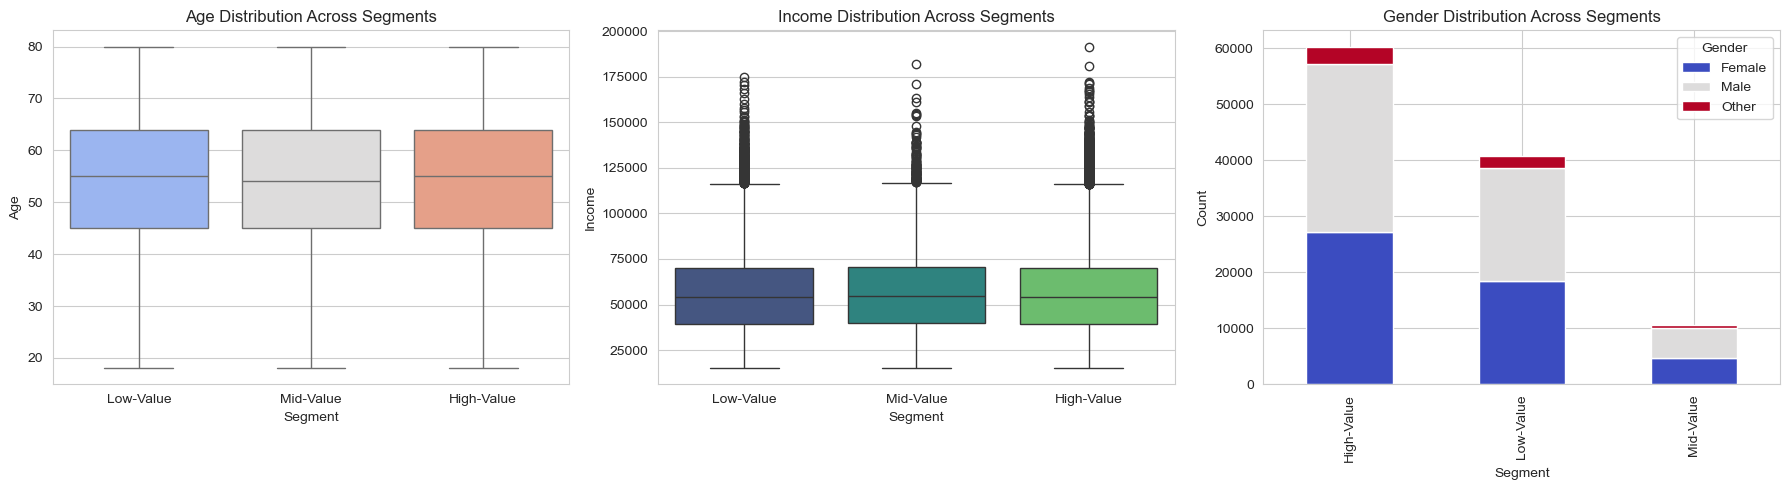

In [ ]:
# Set style for plots
sns.set_style("whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age Distribution (Histogram)
sns.boxplot(x="Segment", y="Age", data=full, palette="coolwarm", ax=axes[0])
axes[0].set_title("Age Distribution Across Segments")
axes[0].set_xlabel("Segment")
axes[0].set_ylabel("Age")

# Income Distribution (Histogram)
sns.boxplot(x="Segment", y="Income", data=full, palette="viridis", ax=axes[1])
axes[1].set_title("Income Distribution Across Segments")
axes[1].set_xlabel("Segment")
axes[1].set_ylabel("Income")

# Gender Distribution (Bar Plot)
gender_counts = full.groupby(["Segment", "Gender"]).size().unstack()
gender_counts.plot(kind="bar", stacked=True, colormap="coolwarm", ax=axes[2])
axes[2].set_title("Gender Distribution Across Segments")
axes[2].set_xlabel("Segment")
axes[2].set_ylabel("Count")
axes[2].legend(title="Gender")

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
sub_low_demo.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_demo_low.csv')
sub_mid_demo.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_demo_mid.csv')
sub_high_demo.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_demo_high.csv')
full.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_demo_full.csv')

In [ ]:
eda_low = {
    "Total Low-Value Customers": len(sub_low_demo),
    "Unique Brands": sub_low_demo["BRAND"].nunique(),
    "Subscription Terms": sub_low_demo["CURRENT_TERM"].value_counts().to_dict(),
    "Average Recency": sub_low_demo["RECENCY"].mean(),
    "Average Frequency": sub_low_demo["FREQUENCY"].mean(),
    "Average Monetary Value": sub_low_demo["REVENUE_RECALC"].mean(),
    "Resubscriber Rate": sub_low_demo["RESUBSCRIBER"].mean(),
    "Age Distribution": sub_low_demo["Age"].describe(),
    "Income Distribution": sub_low_demo["Income"].describe(),
    "Gender Distribution": sub_low_demo["Gender"].value_counts(normalize=True).to_dict(),
    "Location Breakdown": sub_low_demo["Location"].value_counts().head(5).to_dict(),
}
eda_low

{'Total Low-Value Customers': 40819,
 'Unique Brands': 5,
 'Subscription Terms': {'monthly': 40197, 'annual': 622},
 'Average Recency': 31.85447953159068,
 'Average Frequency': 1.0280261642862392,
 'Average Monetary Value': 17.776742693353587,
 'Resubscriber Rate': 0.025453832773953307,
 'Age Distribution': count    40819.000000
 mean        54.405056
 std         13.444562
 min         18.000000
 25%         45.000000
 50%         55.000000
 75%         64.000000
 max         80.000000
 Name: Age, dtype: float64,
 'Income Distribution': count     40819.000000
 mean      55425.941694
 std       22899.732335
 min       15000.000000
 25%       39185.500000
 50%       54134.000000
 75%       70061.500000
 max      174998.000000
 Name: Income, dtype: float64,
 'Gender Distribution': {'Male': 0.4967539626154487,
  'Female': 0.4510889536735344,
  'Other': 0.052157083711016926},
 'Location Breakdown': {'New Michael': 53,
  'Port Michael': 36,
  'North John': 35,
  'South James': 34,
  'South 

In [ ]:
eda_mid = {
    "Total Low-Value Customers": len(sub_mid_demo),
    "Unique Brands": sub_mid_demo["BRAND"].nunique(),
    "Subscription Terms": sub_mid_demo["CURRENT_TERM"].value_counts().to_dict(),
    "Average Recency": sub_mid_demo["RECENCY"].mean(),
    "Average Frequency": sub_mid_demo["FREQUENCY"].mean(),
    "Average Monetary Value": sub_mid_demo["REVENUE_RECALC"].mean(),
    "Resubscriber Rate": sub_mid_demo["RESUBSCRIBER"].mean(),
    "Age Distribution": sub_mid_demo["Age"].describe(),
    "Income Distribution": sub_mid_demo["Income"].describe(),
    "Gender Distribution": sub_mid_demo["Gender"].value_counts(normalize=True).to_dict(),
    "Location Breakdown": sub_mid_demo["Location"].value_counts().head(5).to_dict(),
}
eda_mid

{'Total Low-Value Customers': 10663,
 'Unique Brands': 5,
 'Subscription Terms': {'annual': 5673, 'monthly': 4990},
 'Average Recency': 83.54890743693144,
 'Average Frequency': 1.1259495451561474,
 'Average Monetary Value': 47.14212416768265,
 'Resubscriber Rate': 0.0955641001594298,
 'Age Distribution': count    10663.000000
 mean        54.392291
 std         13.406855
 min         18.000000
 25%         45.000000
 50%         54.000000
 75%         64.000000
 max         80.000000
 Name: Age, dtype: float64,
 'Income Distribution': count     10663.000000
 mean      55777.680859
 std       23047.339650
 min       15000.000000
 25%       39689.500000
 50%       54525.000000
 75%       70591.500000
 max      181940.000000
 Name: Income, dtype: float64,
 'Gender Distribution': {'Male': 0.5067992122292038,
  'Female': 0.44274594391822186,
  'Other': 0.05045484385257432},
 'Location Breakdown': {'Port Michael': 14,
  'West Michael': 13,
  'North Michael': 13,
  'Lake Michael': 12,
  'Sout

In [ ]:
eda_high = {
    "Total Low-Value Customers": len(sub_high_demo),
    "Unique Brands": sub_high_demo["BRAND"].nunique(),
    "Subscription Terms": sub_high_demo["CURRENT_TERM"].value_counts().to_dict(),
    "Average Recency": sub_high_demo["RECENCY"].mean(),
    "Average Frequency": sub_high_demo["FREQUENCY"].mean(),
    "Average Monetary Value": sub_high_demo["REVENUE_RECALC"].mean(),
    "Resubscriber Rate": sub_high_demo["RESUBSCRIBER"].mean(),
    "Age Distribution": sub_high_demo["Age"].describe(),
    "Income Distribution": sub_high_demo["Income"].describe(),
    "Gender Distribution": sub_high_demo["Gender"].value_counts(normalize=True).to_dict(),
    "Location Breakdown": sub_high_demo["Location"].value_counts().head(5).to_dict(),
}
eda_high

{'Total Low-Value Customers': 60186,
 'Unique Brands': 5,
 'Subscription Terms': {'monthly': 34032, 'annual': 26153, 'weekly': 1},
 'Average Recency': 182.87241218888113,
 'Average Frequency': 1.0495962516199782,
 'Average Monetary Value': 80.00076363273851,
 'Resubscriber Rate': 0.0413385172631509,
 'Age Distribution': count    60186.000000
 mean        54.406207
 std         13.431112
 min         18.000000
 25%         45.000000
 50%         55.000000
 75%         64.000000
 max         80.000000
 Name: Age, dtype: float64,
 'Income Distribution': count     60186.000000
 mean      55409.187020
 std       23021.591775
 min       15000.000000
 25%       39212.250000
 50%       54051.500000
 75%       69974.500000
 max      191510.000000
 Name: Income, dtype: float64,
 'Gender Distribution': {'Male': 0.49916924201641577,
  'Female': 0.4513175821619646,
  'Other': 0.04951317582161965},
 'Location Breakdown': {'New Michael': 60,
  'West Michael': 54,
  'North Michael': 51,
  'Port Michae

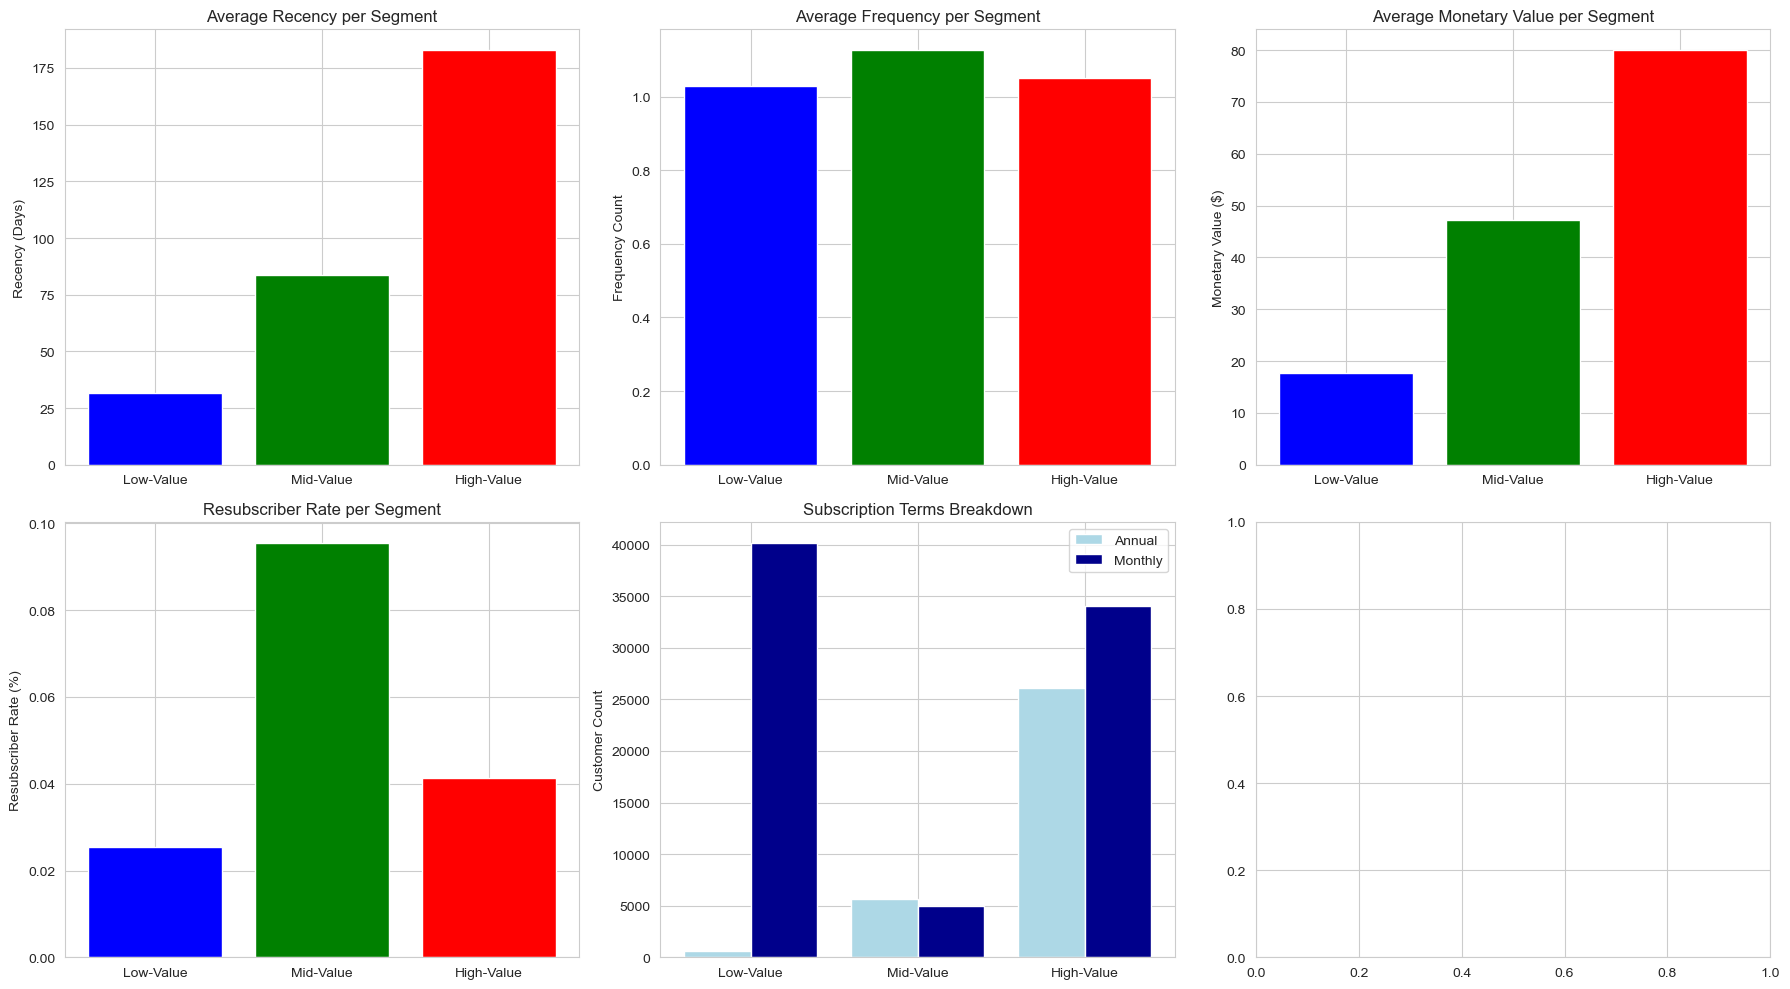

In [ ]:
# Extract values for visualization
segments = ["Low-Value", "Mid-Value", "High-Value"]
avg_revenue = [
    eda_low["Average Recency"],
    eda_mid["Average Recency"],
    eda_high["Average Recency"]
]
avg_frequency = [
    eda_low["Average Frequency"],
    eda_mid["Average Frequency"],
    eda_high["Average Frequency"]
]
avg_monetary = [
    eda_low["Average Monetary Value"],
    eda_mid["Average Monetary Value"],
    eda_high["Average Monetary Value"]
]
resubscriber_rate = [
    eda_low["Resubscriber Rate"],
    eda_mid["Resubscriber Rate"],
    eda_high["Resubscriber Rate"]
]
subscription_terms = {
    "Annual": [
        eda_low["Subscription Terms"].get("annual", 0),
        eda_mid["Subscription Terms"].get("annual", 0),
        eda_high["Subscription Terms"].get("annual", 0)
    ],
    "Monthly": [
        eda_low["Subscription Terms"].get("monthly", 0),
        eda_mid["Subscription Terms"].get("monthly", 0),
        eda_high["Subscription Terms"].get("monthly", 0)
    ]
}

# Extract key metrics for visualization
segments = ["Low-Value", "Mid-Value", "High-Value"]

# Data to be visualized
avg_recency = [
    eda_low["Average Recency"],
    eda_mid["Average Recency"],
    eda_high["Average Recency"]
]

avg_frequency = [
    eda_low["Average Frequency"],
    eda_mid["Average Frequency"],
    eda_high["Average Frequency"]
]

avg_monetary = [
    eda_low["Average Monetary Value"],
    eda_mid["Average Monetary Value"],
    eda_high["Average Monetary Value"]
]

resubscriber_rate = [
    eda_low["Resubscriber Rate"],
    eda_mid["Resubscriber Rate"],
    eda_high["Resubscriber Rate"]
]

# Subscription Terms Breakdown
subscription_terms = {
    "Annual": [
        eda_low["Subscription Terms"].get("annual", 0),
        eda_mid["Subscription Terms"].get("annual", 0),
        eda_high["Subscription Terms"].get("annual", 0)
    ],
    "Monthly": [
        eda_low["Subscription Terms"].get("monthly", 0),
        eda_mid["Subscription Terms"].get("monthly", 0),
        eda_high["Subscription Terms"].get("monthly", 0)
    ]
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot Average Recency
axes[0, 0].bar(segments, avg_recency, color=['blue', 'green', 'red'])
axes[0, 0].set_title("Average Recency per Segment")
axes[0, 0].set_ylabel("Recency (Days)")

# Plot Average Frequency
axes[0, 1].bar(segments, avg_frequency, color=['blue', 'green', 'red'])
axes[0, 1].set_title("Average Frequency per Segment")
axes[0, 1].set_ylabel("Frequency Count")

# Plot Average Monetary Value
axes[0, 2].bar(segments, avg_monetary, color=['blue', 'green', 'red'])
axes[0, 2].set_title("Average Monetary Value per Segment")
axes[0, 2].set_ylabel("Monetary Value ($)")

# Plot Resubscriber Rate
axes[1, 0].bar(segments, resubscriber_rate, color=['blue', 'green', 'red'])
axes[1, 0].set_title("Resubscriber Rate per Segment")
axes[1, 0].set_ylabel("Resubscriber Rate (%)")

# Plot Subscription Term Distribution
x = np.arange(len(segments))
width = 0.4

axes[1, 1].bar(x - width/2, subscription_terms["Annual"], width, label='Annual', color='lightblue')
axes[1, 1].bar(x + width/2, subscription_terms["Monthly"], width, label='Monthly', color='darkblue')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(segments)
axes[1, 1].set_title("Subscription Terms Breakdown")
axes[1, 1].set_ylabel("Customer Count")
axes[1, 1].legend()

# Display plots
plt.tight_layout()
plt.show()

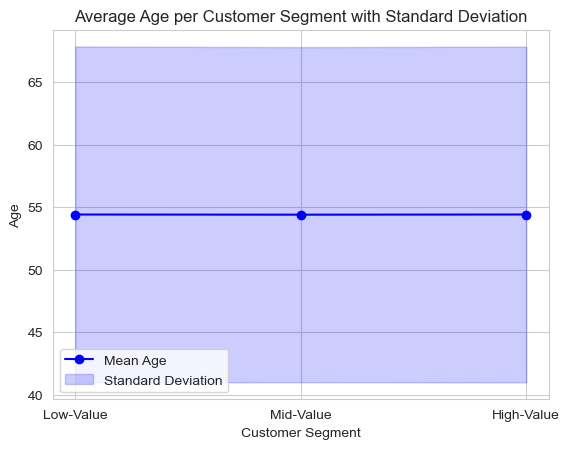

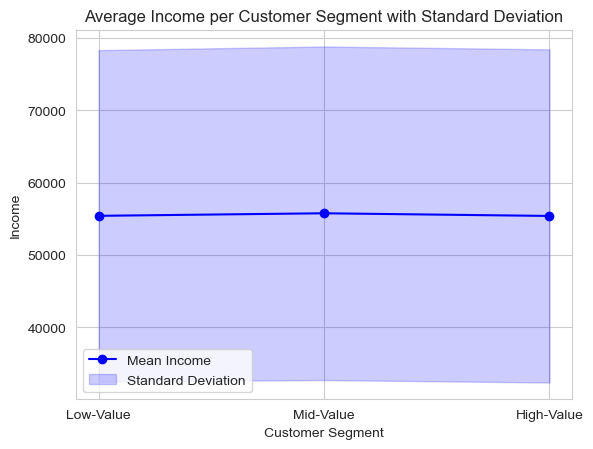

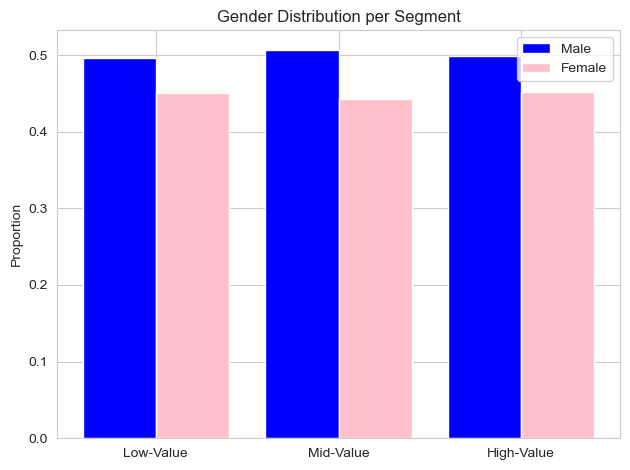

In [ ]:
# Extracting relevant data from the summary dictionaries
segments = ["Low-Value", "Mid-Value", "High-Value"]

# Age statistics
age_mean = [
    eda_low["Age Distribution"]["mean"],
    eda_mid["Age Distribution"]["mean"],
    eda_high["Age Distribution"]["mean"]
]

age_std = [
    eda_low["Age Distribution"]["std"],
    eda_mid["Age Distribution"]["std"],
    eda_high["Age Distribution"]["std"]
]

# Convert segments into numerical indices for plotting
x = np.arange(len(segments))

# Plot the line graph for Age Mean
plt.plot(x, age_mean, marker='o', linestyle='-', color='blue', label="Mean Age")

# Add shaded region for standard deviation (Error bars)
plt.fill_between(x, np.array(age_mean) - np.array(age_std), np.array(age_mean) + np.array(age_std), 
                 color='blue', alpha=0.2, label="Standard Deviation")

# Customize the plot
plt.xticks(x, segments)  # Set x-axis labels
plt.xlabel("Customer Segment")
plt.ylabel("Age")
plt.title("Average Age per Customer Segment with Standard Deviation")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Income statistics
income_mean = [
    eda_low["Income Distribution"]["mean"],
    eda_mid["Income Distribution"]["mean"],
    eda_high["Income Distribution"]["mean"]
]

income_std = [
    eda_low["Income Distribution"]["std"],
    eda_mid["Income Distribution"]["std"],
    eda_high["Income Distribution"]["std"]
]

# Convert segments into numerical indices for plotting
x = np.arange(len(segments))

# Plot the line graph for Age Mean
plt.plot(x, income_mean, marker='o', linestyle='-', color='blue', label="Mean Income")

# Add shaded region for standard deviation (Error bars)
plt.fill_between(x, np.array(income_mean) - np.array(income_std), np.array(income_mean) + np.array(income_std), 
                 color='blue', alpha=0.2, label="Standard Deviation")

# Customize the plot
plt.xticks(x, segments)  # Set x-axis labels
plt.xlabel("Customer Segment")
plt.ylabel("Income")
plt.title("Average Income per Customer Segment with Standard Deviation")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Gender distribution
gender_male = [
    eda_low["Gender Distribution"].get("Male", 0),
    eda_mid["Gender Distribution"].get("Male", 0),
    eda_high["Gender Distribution"].get("Male", 0)
]

gender_female = [
    eda_low["Gender Distribution"].get("Female", 0),
    eda_mid["Gender Distribution"].get("Female", 0),
    eda_high["Gender Distribution"].get("Female", 0)
]

plt.bar(x - width / 2, gender_male, width, label='Male', color='blue')
plt.bar(x + width / 2, gender_female, width, label='Female', color='pink')
plt.xticks(x, labels=segments)
plt.title("Gender Distribution per Segment")
plt.ylabel("Proportion")
plt.legend()

# Display plots
plt.tight_layout()
plt.show()


# Sub visualization
## RFM, Resub across HML

In [334]:
# read in 
sub = pd.read_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_segment.csv')
select_feat = ['Capstone_id', 'SUB_START', 'SUB_END', 'BRAND', 'CURRENT_TERM', 'RESUBSCRIBER',
       'recency', 'FREQUENCY', 'monetary_1', 'recency_cluster', 'frequency_cluster', 'monetary_cluster',
       'segment', 'monetary_2',]
sub = sub[select_feat]
sub.rename(columns={'FREQUENCY':'frequency'}, inplace=True)

In [342]:
sub.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_segment_selected_feat.csv')

In [336]:
# Grouping data by 'Segment' and calculating key statistics
segment_summary = sub.groupby("segment").agg({
    "recency": ["mean", "median"],
    "frequency": ["mean", "median"],
    "monetary_1": ["mean", "sum"],
    "RESUBSCRIBER": ["mean"]
}).round(2)
segment_summary

recency        frequency        monetary_1             RESUBSCRIBER
           mean median      mean median       mean         sum         mean
segment                                                                    
1         32.18   32.0      1.03    1.0      17.12   638468.80         0.03
2         93.88   90.0      1.13    1.0      36.64   893123.40         0.11
3        111.95  150.0      1.01    1.0      62.52  2184648.54         0.01

## Distribution across segment
### Recency & Frequency

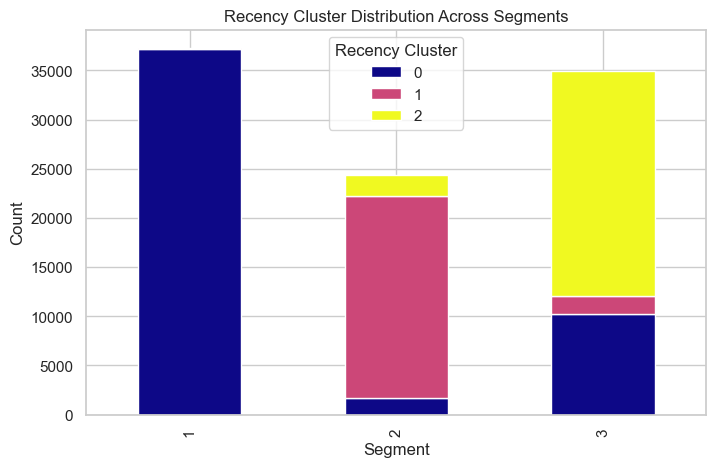

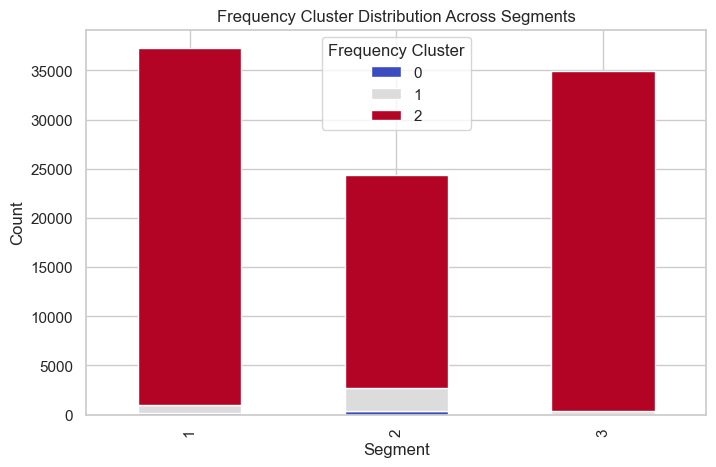

In [340]:
# Count distribution of Recency and Frequency Clusters
recency_cluster_counts = sub.groupby("segment")["recency_cluster"].value_counts().unstack()
frequency_cluster_counts = sub.groupby("segment")["frequency_cluster"].value_counts().unstack()

# Plot Recency Cluster Distribution
recency_cluster_counts.plot(kind="bar", stacked=True, figsize=(8,5), colormap="plasma")
plt.title("Recency Cluster Distribution Across Segments")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.legend(title="Recency Cluster")
plt.show()

# Plot Frequency Cluster Distribution
frequency_cluster_counts.plot(kind="bar", stacked=True, figsize=(8,5), colormap="coolwarm")
plt.title("Frequency Cluster Distribution Across Segments")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.legend(title="Frequency Cluster")
plt.show()


### Monetary value boxplot

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_4011/640037345.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




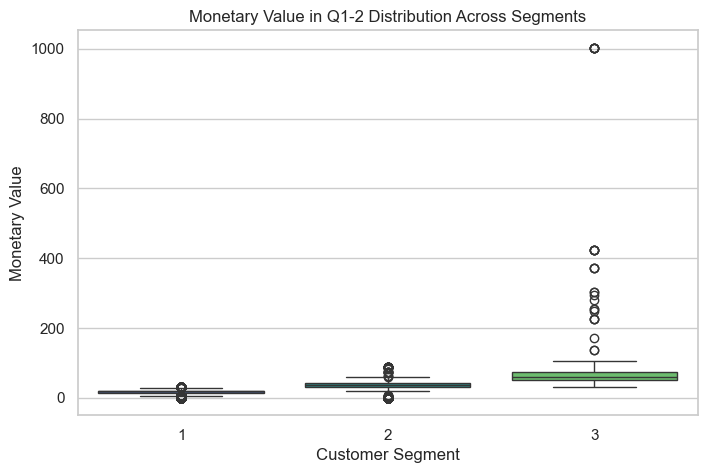

In [337]:
# Boxplot for Revenue by Segment
plt.figure(figsize=(8,5))
sns.boxplot(x="segment", y="monetary_1", data=sub, palette="viridis")
plt.title("Monetary Value in Q1-2 Distribution Across Segments")
plt.xlabel("Customer Segment")
plt.ylabel("Monetary Value")
plt.show()

### Sub term distribution

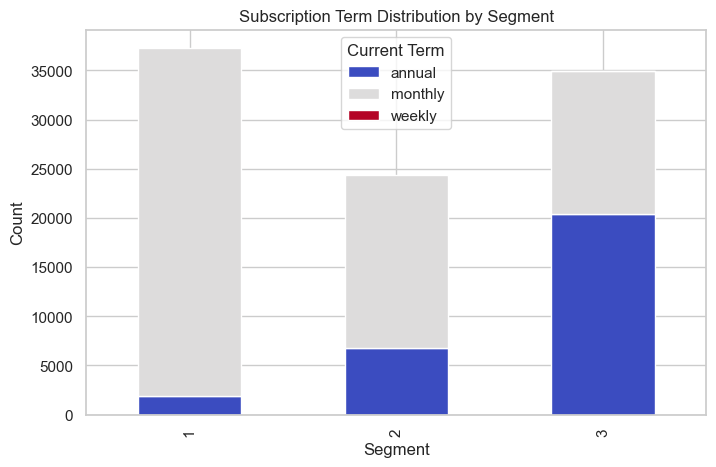

In [338]:
# Count of subscription terms by segment
term_counts = sub.groupby(["segment", "CURRENT_TERM"]).size().unstack()

# Plot distribution of subscription terms across segments
term_counts.plot(kind="bar", stacked=True, figsize=(8,5), colormap="coolwarm")
plt.title("Subscription Term Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.legend(title="Current Term")
plt.show()

In [339]:
# Calculate the percentage of annual/monthly subscriptions within each segment
term_counts_percentage = term_counts.div(term_counts.sum(axis=1), axis=0) * 100
term_counts_percentage

CURRENT_TERM,annual,monthly,weekly
segment,,,
1,4.980822,95.019178,NaN
2,27.951916,72.048084,NaN
3,58.430632,41.566506,0.002862


# --DISREGARD--
Demo Stats

In [ ]:
demo.columns

Index(['Capstone_id', 'Age', 'Gender', 'Location', 'Email', 'Income'], dtype='object')

## Age

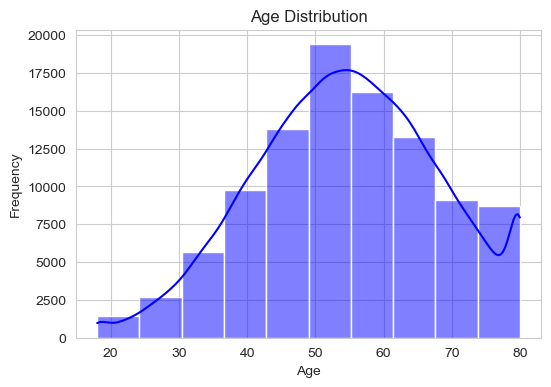

In [ ]:
# Age Distribution Plot
plt.figure(figsize=(6,4))
sns.histplot(demo["Age"], bins=10, kde=True, color="blue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

## Gender

In [ ]:
# Gender Distribution
gender_counts = demo["Gender"].value_counts()
gender_counts

Gender
Male      49853
Female    45078
Other      5069
Name: count, dtype: int64

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_3445/1507335075.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




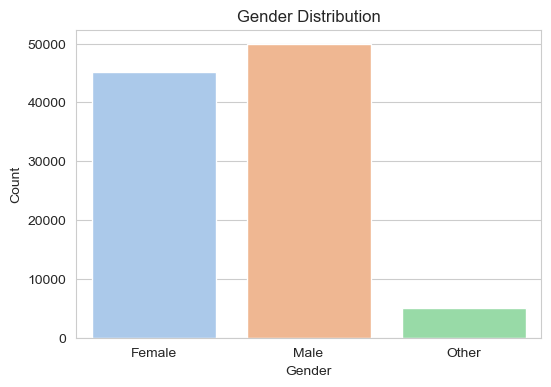

In [ ]:
# Gender Count Plot
plt.figure(figsize=(6,4))
sns.countplot(x=demo["Gender"], palette="pastel")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

## Income

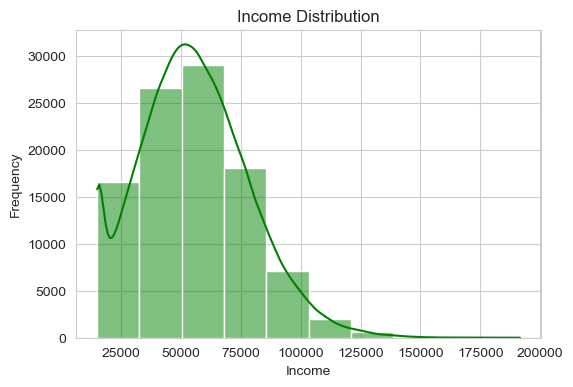

In [ ]:
# Income Distribution Plot
plt.figure(figsize=(6,4))
sns.histplot(demo["Income"], bins=10, kde=True, color="green")
plt.title("Income Distribution")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_3445/1726537035.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




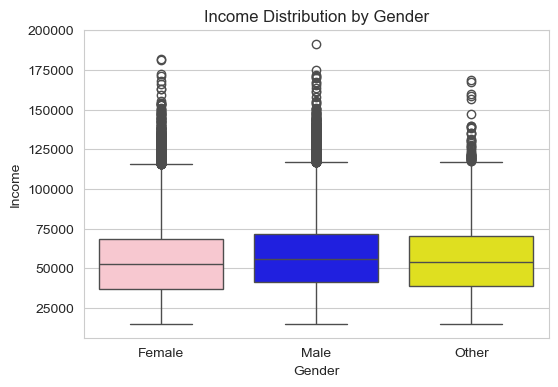

In [ ]:
# Compare income distribution between male and female
plt.figure(figsize=(6,4))
sns.boxplot(x="Gender", y="Income", data=demo, palette={"Male": "blue", "Female": "pink", "Other":"yellow"})
plt.title("Income Distribution by Gender")
plt.show()

## Location

In [ ]:
# Most common customer locations
top_locations = demo["Location"].value_counts().head(5)
top_locations

Location
New Michael      105
Port Michael      87
South Michael     85
North Michael     85
West Michael      84
Name: count, dtype: int64

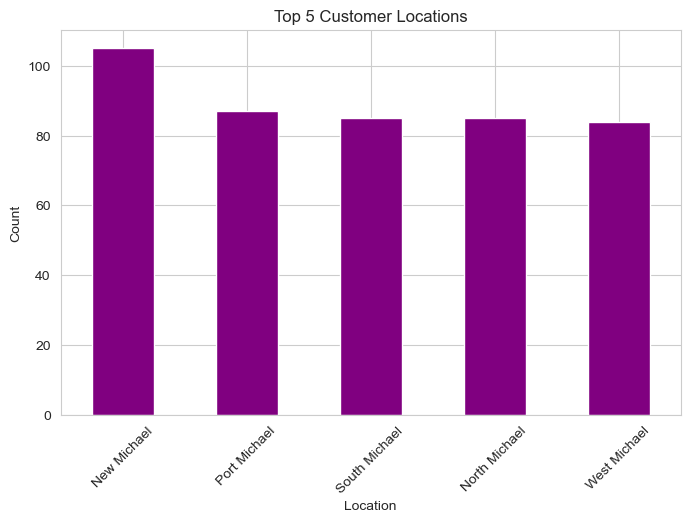

In [ ]:
plt.figure(figsize=(8,5))
top_locations.plot(kind="bar", color="purple")
plt.xlabel("Location")
plt.ylabel("Count")
plt.title("Top 5 Customer Locations")
plt.xticks(rotation=45)
plt.show()

## Clustering

Based on full demo data (w/o mapping to sub data's segmentation), the most determinant factor on clustering is `income`. No big difference across various genders and/or ages.

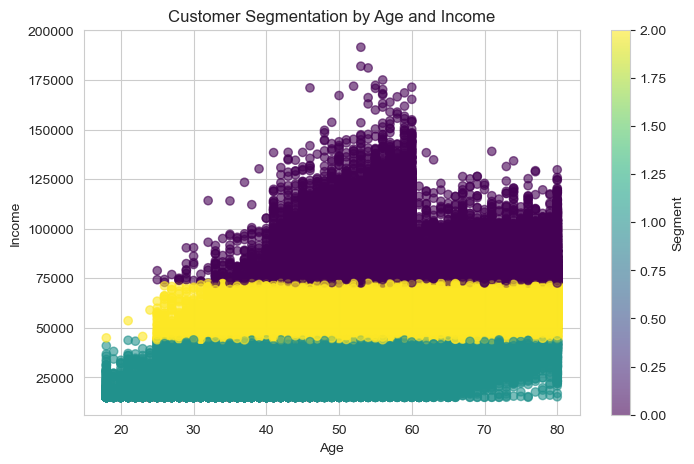

In [ ]:
from sklearn.cluster import KMeans

# Select numerical features for clustering
X = demo[["Age", "Income"]]

# Apply K-Means with 3 clusters (Low, Mid, High)
kmeans = KMeans(n_clusters=3, random_state=42)
demo["Segment"] = kmeans.fit_predict(X)

# Visualizing clusters
plt.figure(figsize=(8,5))
plt.scatter(demo["Age"], demo["Income"], c=demo["Segment"], cmap="viridis", alpha=0.6)
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Customer Segmentation by Age and Income")
plt.colorbar(label="Segment")
plt.show()


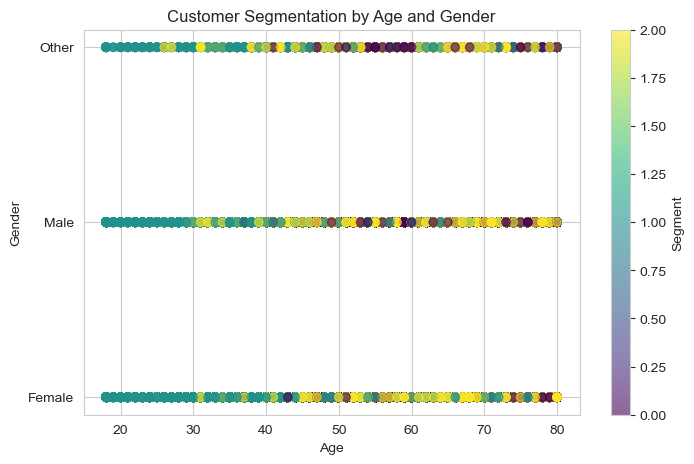

In [ ]:
# Visualizing clusters
plt.figure(figsize=(8,5))
plt.scatter(demo["Age"], demo["Gender"], c=demo["Segment"], cmap="viridis", alpha=0.6)
plt.xlabel("Age")
plt.ylabel("Gender")
plt.title("Customer Segmentation by Age and Gender")
plt.colorbar(label="Segment")
plt.show()

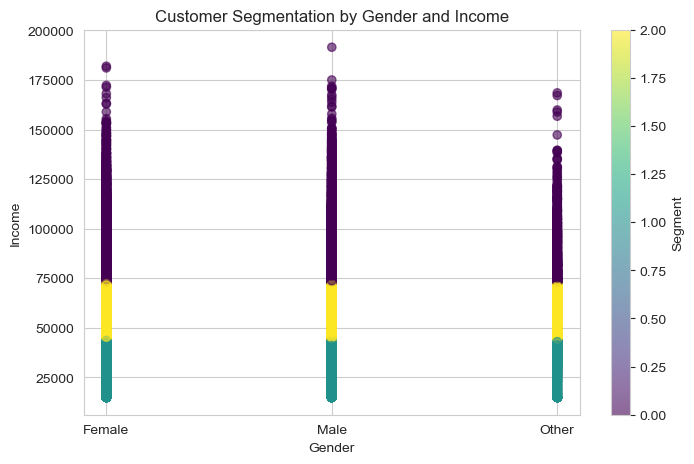

In [ ]:
# Visualizing clusters
plt.figure(figsize=(8,5))
plt.scatter(demo["Gender"], demo["Income"], c=demo["Segment"], cmap="viridis", alpha=0.6)
plt.xlabel("Gender")
plt.ylabel("Income")
plt.title("Customer Segmentation by Gender and Income")
plt.colorbar(label="Segment")
plt.show()

# Churn & LTV Analysis
## Multi-subscriber
create a new feature named ‘MultipleSubscriber’ and use one hot encoding to code capstone ids who subscribed to more than one brand. 

In [345]:
sub_prep = pd.read_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_segment_selected_feat.csv')
sub_prep.columns

Index(['Unnamed: 0', 'Capstone_id', 'SUB_START', 'SUB_END', 'BRAND',
       'CURRENT_TERM', 'RESUBSCRIBER', 'recency', 'frequency', 'monetary_1',
       'recency_cluster', 'frequency_cluster', 'monetary_cluster', 'segment',
       'monetary_2'],
      dtype='object')

In [346]:
# Identify users subscribing to multiple brands
multi_brand_users = sub_prep.groupby('Capstone_id')['BRAND'].nunique() > 1

# # Identify users who subscribed multiple times within a brand
# multi_frequency_users = sub_prep.groupby('Capstone_id')['FREQUENCY'].max() > 1

# Combine both conditions
sub_prep['multi_sub'] = sub_prep['Capstone_id'].map(
    lambda x: int(multi_brand_users.get(x, True))
)
sub_prep = sub_prep.drop('Unnamed: 0', axis=1)
sub_prep.head()

,Capstone_id,SUB_START,SUB_END,BRAND,CURRENT_TERM,RESUBSCRIBER,recency,frequency,monetary_1,recency_cluster,frequency_cluster,monetary_cluster,segment,monetary_2,multi_sub
0,ETM3560501,2024-02-27,2024-03-05,PULSE,monthly,0,7,1,11.99,0,2,0,1,0.0,0
1,ZLE5622372,2024-02-01,2024-03-04,PULSE,monthly,0,32,1,23.98,0,2,0,1,0.0,0
2,RAJ3140438,2024-05-17,2024-10-01,PULSE,monthly,0,44,1,19.25,0,2,0,1,40.7,1
3,PPZ7199683,2024-02-01,2024-03-04,PULSE,annual,0,32,1,86.88,0,2,2,3,0.0,0
4,PAO4909132,2024-02-01,2024-05-17,PULSE,monthly,0,106,1,47.96,1,2,1,2,0.0,0


multi_sub
0    81.526071
1    18.473929
Name: proportion, dtype: float64


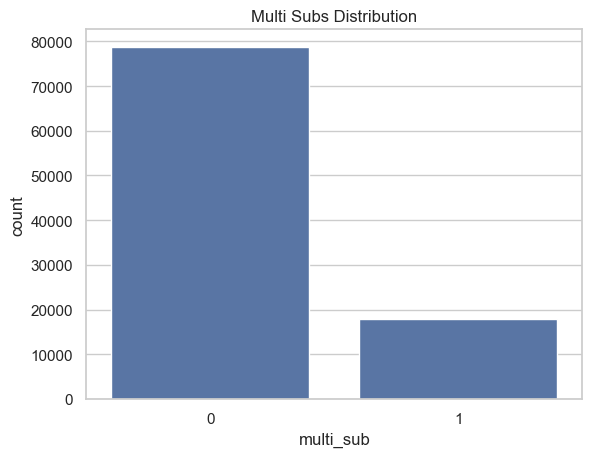

In [349]:
# Display the percentage
print(sub_prep['multi_sub'].value_counts(normalize=True) * 100)

sns.countplot(x=sub_prep['multi_sub'])
plt.title("Multi Subs Distribution")
plt.show()

## Churned
if `SUB_END` not in first 6 months, meaning the user doesn't cancel subscription, then `Churned` is 0, otherwise is 1.
- solve imbalanced data issue when using time sensitive data split method

In [354]:
sub_prep['churned'] = ((sub_prep['SUB_END']>=sub_prep['SUB_START']) & (sub_prep['SUB_END']<='2024-06-30')).astype(int)
print(f'Churn Rate: {sub_prep.churned.mean()}')

Churn Rate: 0.5037939565843004


## LTV labeling
create ground truth LTV label based on monetary value in the last 6 month for prediction

In [355]:
sub_prep.columns

Index(['Capstone_id', 'SUB_START', 'SUB_END', 'BRAND', 'CURRENT_TERM',
       'RESUBSCRIBER', 'recency', 'frequency', 'monetary_1', 'recency_cluster',
       'frequency_cluster', 'monetary_cluster', 'segment', 'monetary_2',
       'multi_sub', 'churned'],
      dtype='object')

In [356]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(sub_prep[['monetary_2']])
sub_prep['LTV_cluster'] = kmeans.predict(sub_prep[['monetary_2']])
sub_prep = order_cluster('LTV_cluster', 'monetary_2', sub_prep, True)
sub_prep.groupby('LTV_cluster')['monetary_2'].describe()

,count,mean,std,min,25%,50%,75%,max
LTV_cluster,,,,,,,,
0,55667.0,0.667683,2.831068,0.00,0.00,0.00,0.00,18.03
1,21849.0,35.440928,6.009152,18.07,31.98,37.56,40.64,43.32
2,19085.0,51.252690,11.284211,43.35,46.31,50.34,54.26,444.97


In [357]:
sub_prep.columns

Index(['Capstone_id', 'SUB_START', 'SUB_END', 'BRAND', 'CURRENT_TERM',
       'RESUBSCRIBER', 'recency', 'frequency', 'monetary_1', 'recency_cluster',
       'frequency_cluster', 'monetary_cluster', 'segment', 'monetary_2',
       'multi_sub', 'churned', 'LTV_cluster'],
      dtype='object')

## Train-Val-Test split
Percentage: 70,15,15

In [358]:
# Split data into train (70%), validation (15%), and test (15%)
sub_train_pct, temp_df = train_test_split(sub_prep, test_size=0.3, random_state=42)  # First, split off 30% for val+test
sub_val_pct, sub_test_pct = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split remaining 30% into equal halves

# Print dataset sizes
print(f"Train size: {len(sub_train_pct)}, Validation size: {len(sub_val_pct)}, Test size: {len(sub_test_pct)}")

Train size: 67620, Validation size: 14490, Test size: 14491


In [361]:
print(f'''Churn Rate: 
Train: {sub_train_pct.churned.mean()}, 
Validation: {sub_val_pct.churned.mean()}, 
Test: {sub_test_pct.churned.mean()}''')

sub_train_pct.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_train.csv')
sub_val_pct.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_val.csv')
sub_test_pct.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_test.csv')

Churn Rate: 
Train: 0.5043626146110618, 
Validation: 0.5065562456866805, 
Test: 0.4983783037747567


### --DISREGARD--
Time sensitive
- training: 1/1 - 6/30
    - 1 Churned if sub end is in first 6, and 0 if sub end is not in first 6
- validation: 7/1 - 9/30
    - 1 Churn if sub end in July 1 to Sep. 30, and 0 if sub end is greater in Sep 30 then not churned
- test: 10/1 - 11/1
    - 1 Churn if sub end in Oct 1 to Nov 1 of 2024, 0 if greater in Nov then not churned

In [169]:
train_beg, train_end = '2024-01-01', '2024-06-30'
val_beg, val_end = '2024-07-01', '2024-09-30'
test_beg, test_end = '2024-10-01', '2024-11-01'

In [172]:
sub_train = sub_prep[(sub_prep['SUB_START']>=train_beg) & (sub_prep['SUB_END']<=train_end)]
sub_val = sub_prep[(sub_prep['SUB_START']>=val_beg) & (sub_prep['SUB_END']<=val_end)]
sub_test = sub_prep[(sub_prep['SUB_START']>=test_beg) & (sub_prep['SUB_END']<=test_end)]

In [174]:
sub_train['Churned'] = ((sub_train['SUB_END']>=train_beg) & (sub_train['SUB_END']<=train_end)).astype(int)
sub_val['Churned'] = ((sub_val['SUB_END']>=val_beg) & (sub_val['SUB_END']<=val_end)).astype(int)
sub_test['Churned'] = ((sub_test['SUB_END']>=test_beg) & (sub_test['SUB_END']<=test_end)).astype(int)

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_4011/150776618.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_4011/150776618.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_4011/150776618.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [195]:
print('Original # Rows', sub_prep.shape[0])
print('# Rows', sub_train.shape[0], sub_val.shape[0], sub_test.shape[0])
print('Churn Rate', sub_train['Churned'].mean(), sub_val['Churned'].mean(), sub_test['Churned'].mean())

Original # Rows 111668
# Rows 48667 2189 2593
Churn Rate 1.0 1.0 1.0


In [177]:
sub_train = sub_train.drop('Unnamed: 0', axis=1)
sub_val = sub_val.drop('Unnamed: 0', axis=1)
sub_test = sub_test.drop('Unnamed: 0', axis=1)

In [178]:
sub_train.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_train.csv')
sub_val.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_val.csv')
sub_test.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_test.csv')

## --DISREGARD--
LTV label based on monetary value only since segment will based on RFM over the whole time frame:
- train (1.1-6.30): 7.1-9.30
- val (7.1-9.30): 10.1-11.1
- test (10.1-11.1): 11.1-12.1

In [247]:
sub_train_id = sub_train['Capstone_id']
sub_val_filtered = sub_val[sub_val['Capstone_id'].isin(sub_train_id)][['Capstone_id', 'BRAND', 'Segment', 'REVENUE_RECALC']]

# training set LTV label based on validation segment which depends on RFM
sub_train_segment = sub_train.merge(sub_val_filtered[['Capstone_id', 'Segment']], on='Capstone_id', how='inner')

# training set LTV label based on validation monetary value only
sub_train_monetary = sub_train.merge(sub_val_filtered[['Capstone_id', 'REVENUE_RECALC']], on='Capstone_id', how='inner')

print(sub_train_segment.shape[0], sub_train_segment['Capstone_id'].nunique())
print(sub_train_monetary.shape[0], sub_train_monetary['Capstone_id'].nunique())
print(sub_train_segment.shape[0]/sub_train.shape[0], sub_train_monetary.shape[0]/sub_train.shape[0])

88 83
88 83
0.001808206793104157 0.001808206793104157


In [180]:
sub_train_monetary = sub_train_monetary.rename(columns={'REVENUE_RECALC_x':'Revenue_Recalc', 'REVENUE_RECALC_y':'Revenue_3m'})

kmeans = KMeans(n_clusters=3)
kmeans.fit(sub_train_monetary[['Revenue_3m']])
sub_train_monetary['LTVCluster'] = kmeans.predict(sub_train_monetary[['Revenue_3m']])
sub_train_monetary = order_cluster('LTVCluster', 'Revenue_3m', sub_train_monetary, True)
sub_train_monetary.groupby('LTVCluster')['Revenue_3m'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,65.0,10.051538,1.401750,7.99,8.99,9.99,11.99,11.99
1,18.0,21.590000,5.028638,15.98,17.98,20.98,23.98,35.97
2,5.0,80.924000,6.608603,72.99,74.88,82.99,86.88,86.88


In [181]:
sub_train_monetary.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_train_LTV.csv')

In [182]:
sub_train_monetary

,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id,...,Revenue_Recalc,REVENUE_RECALC_Cluster,RECENCY_Cluster,FREQUENCY_Cluster,Score,Segment,MultipleSubscriber,Churned,Revenue_3m,LTVCluster
0,106,2024-02-01,2024-05-17,1,monthly,7.99,95.88,0,PULSE,AWX3762713,...,31.96,0,1,2,0.7,2,1,1,8.99,0
1,32,2024-04-28,2024-05-30,1,monthly,10.99,131.88,0,LIMELIGHT,AGF5923600,...,21.98,0,0,2,0.4,1,1,1,7.99,0
2,54,2024-03-24,2024-05-17,1,monthly,11.99,143.88,0,PULSE,GNH0334930,...,23.98,0,0,2,0.4,1,1,1,8.99,0
3,10,2024-05-17,2024-05-27,1,monthly,10.99,131.88,0,LIMELIGHT,PUN4479376,...,10.99,0,0,2,0.4,1,1,1,8.99,0
4,32,2024-02-01,2024-03-04,1,monthly,7.99,95.88,0,CINEQUEST,SXL5055577,...,15.98,0,0,2,0.4,1,1,1,8.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,52,2024-03-26,2024-05-17,1,monthly,8.99,107.88,0,CINEQUEST,CPY1161919,...,17.98,0,0,2,0.4,1,1,1,9.99,0
84,70,2024-03-08,2024-05-17,1,monthly,7.99,95.88,0,PULSE,NNB2392327,...,23.97,0,0,2,0.4,1,1,1,8.99,0
85,22,2024-04-26,2024-05-18,1,monthly,11.99,143.88,0,PULSE,TUD0171949,...,11.99,0,0,2,0.4,1,1,1,8.99,0
86,74,2024-03-04,2024-05-17,1,monthly,7.99,95.88,0,PULSE,LXO4077838,...,23.97,0,0,2,0.4,1,1,1,26.97,1


In [183]:
sub_val_id = sub_val['Capstone_id']
sub_test_filtered = sub_test[sub_test['Capstone_id'].isin(sub_val_id)][['Capstone_id', 'Segment', 'REVENUE_RECALC']]

# training set LTV label based on validation segment which depends on RFM
sub_val_segment = sub_val.merge(sub_test_filtered[['Capstone_id', 'Segment']], on='Capstone_id', how='inner')

# training set LTV label based on validation monetary value only
sub_val_monetary = sub_val.merge(sub_test_filtered[['Capstone_id', 'REVENUE_RECALC']], on='Capstone_id', how='inner')

print(sub_val_segment.shape[0], sub_val_segment['Capstone_id'].nunique())
print(sub_val_monetary.shape[0], sub_val_monetary['Capstone_id'].nunique())
print(sub_val_segment.shape[0]/sub_val.shape[0], sub_val_monetary.shape[0]/sub_val.shape[0])

21 21
21 21
0.009593421653723162 0.009593421653723162


In [184]:
sub_val_monetary = sub_val_monetary.rename(columns={'REVENUE_RECALC_x':'Revenue_Recalc', 'REVENUE_RECALC_y':'Revenue_1m'})

kmeans = KMeans(n_clusters=3)
kmeans.fit(sub_val_monetary[['Revenue_1m']])
sub_val_monetary['LTVCluster'] = kmeans.predict(sub_val_monetary[['Revenue_1m']])
sub_val_monetary = order_cluster('LTVCluster', 'Revenue_1m', sub_val_monetary, True)
sub_val_monetary.groupby('LTVCluster')['Revenue_1m'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,18.0,10.822778,2.227591,7.99,9.9900,9.990,11.9900,17.98
1,1.0,74.880000,NaN,74.88,74.8800,74.880,74.8800,74.88
2,2.0,84.935000,2.750645,82.99,83.9625,84.935,85.9075,86.88


In [185]:
sub_val_monetary.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_val_LTV.csv')

In [186]:
sub_test_id = sub_test['Capstone_id']
sub_nov = sub_prep[(sub_prep['SUB_START']>='2024-11-01') & (sub_prep['SUB_START']<='2024-12-01')]
sub_nov_filtered = sub_nov[sub_nov['Capstone_id'].isin(sub_test_id)][['Capstone_id', 'Segment', 'REVENUE_RECALC']]

# training set LTV label based on validation segment which depends on RFM
sub_test_segment = sub_test.merge(sub_nov_filtered[['Capstone_id', 'Segment']], on='Capstone_id', how='inner')

# training set LTV label based on validation monetary value only
sub_test_monetary = sub_test.merge(sub_nov_filtered[['Capstone_id', 'REVENUE_RECALC']], on='Capstone_id', how='inner')

print(sub_test_segment.shape[0], sub_test_segment['Capstone_id'].nunique())
print(sub_test_monetary.shape[0], sub_test_monetary['Capstone_id'].nunique())
print(sub_test_segment.shape[0]/sub_test.shape[0], sub_test_monetary.shape[0]/sub_test.shape[0])

8 8
8 8
0.0030852294639413806 0.0030852294639413806


In [187]:
sub_test_monetary = sub_test_monetary.rename(columns={'REVENUE_RECALC_x':'Revenue_Recalc', 'REVENUE_RECALC_y':'Revenue_1m'})

kmeans = KMeans(n_clusters=3)
kmeans.fit(sub_test_monetary[['Revenue_1m']])
sub_test_monetary['LTVCluster'] = kmeans.predict(sub_test_monetary[['Revenue_1m']])
sub_test_monetary = order_cluster('LTVCluster', 'Revenue_1m', sub_test_monetary, True)
sub_test_monetary.groupby('LTVCluster')['Revenue_1m'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,4.0,9.740000,0.50000,8.99,9.74,9.99,9.99,9.99
1,3.0,11.323333,0.57735,10.99,10.99,10.99,11.49,11.99
2,1.0,62.990000,NaN,62.99,62.99,62.99,62.99,62.99


In [188]:
sub_test_monetary.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_test_LTV.csv')

## Formatting
### Option 1: ignore multi-subscriber
Since multi sub only is ~20% rows and ~10% unique ids, can separate original dataset into single and multi subs:
- option 2: take single values for multi subs
- option 3: aggregate values into arrays to keep track of everthing for multi subs

In [368]:
print(f'''Full data: 
Single Subs: {sub_prep['multi_sub'].value_counts()[0]} ({round(100*sub_prep['multi_sub'].value_counts(normalize=True)[0],2)} %)
Multi Subs: {sub_prep['multi_sub'].value_counts()[1]} ({round(100*sub_prep['multi_sub'].value_counts(normalize=True)[1],2)} %)''')

Full data: 
Single Subs: 78755 (81.53 %)
Multi Subs: 17846 (18.47 %)


In [369]:
sub_train_single = sub_train_pct[sub_train_pct['multi_sub']==0]
sub_train_multi = sub_train_pct[sub_train_pct['multi_sub']==1]
print(f'Train: Single Subs: {sub_train_single.shape[0]} ({round(100*sub_train_single.shape[0]/sub_train_pct.shape[0], 2)} %),\
     Multi Subs: {sub_train_multi.shape[0]} ({round(100*sub_train_multi.shape[0]/sub_train_pct.shape[0], 2)} %)')

sub_val_single = sub_val_pct[sub_val_pct['multi_sub']==0]
sub_val_multi = sub_val_pct[sub_val_pct['multi_sub']==1]
print(f'Validation: Single Subs: {sub_val_single.shape[0]} ({round(100*sub_val_single.shape[0]/sub_val_pct.shape[0], 2)} %),\
     Multi Subs: {sub_val_multi.shape[0]} ({round(100*sub_val_multi.shape[0]/sub_val_pct.shape[0], 2)} %)')

sub_test_single = sub_test_pct[sub_test_pct['multi_sub']==0]
sub_test_multi = sub_test_pct[sub_test_pct['multi_sub']==1]
print(f'Test: Single Subs: {sub_test_single.shape[0]} ({round(100*sub_test_single.shape[0]/sub_test_pct.shape[0], 2)} %),\
     Multi Subs: {sub_test_multi.shape[0]} ({round(100*sub_test_multi.shape[0]/sub_test_pct.shape[0], 2)} %)')

Train: Single Subs: 55105 (81.49 %),     Multi Subs: 12515 (18.51 %)
Validation: Single Subs: 11753 (81.11 %),     Multi Subs: 2737 (18.89 %)
Test: Single Subs: 11897 (82.1 %),     Multi Subs: 2594 (17.9 %)


In [378]:
sub_train_multi.columns

Index(['Capstone_id', 'SUB_START', 'SUB_END', 'BRAND', 'CURRENT_TERM',
       'RESUBSCRIBER', 'recency', 'frequency', 'monetary_1', 'recency_cluster',
       'frequency_cluster', 'monetary_cluster', 'segment', 'monetary_2',
       'multi_sub', 'churned', 'LTV_cluster'],
      dtype='object')

### Option 2: 
- take min sub start and max sub end
- calculate recency of multi subs using the max recency, and sum frequency and monetary values
- re-cluster RFM

In [380]:
# Recalc RFM and reclustering
def recluster_rfm_option2(option2_multi_df, perform_kmeans, order_cluster):
    option2_df = option2_multi_df.groupby('Capstone_id', as_index=False).agg({
        'SUB_START':'min', 'SUB_END':'max', 'multi_sub': 'first', 'BRAND': list,
        'CURRENT_TERM': list, 'RESUBSCRIBER': list,
        'recency':'max', 'frequency':'sum', 'monetary_1':'sum',
        'monetary_2': list, 'multi_sub': list, 'churned': list, 'LTV_cluster': list
    })

    option2_df = perform_kmeans(option2_df, 'recency', 3, 'recency_cluster')
    option2_df = order_cluster('recency_cluster', 'recency', option2_df, True)

    option2_df = perform_kmeans(option2_df, 'frequency', 3, 'frequency_cluster')
    option2_df = order_cluster('frequency_cluster', 'frequency', option2_df, False)

    option2_df = perform_kmeans(option2_df, 'monetary_1', 3, 'monetary_cluster')
    option2_df = order_cluster('monetary_cluster', 'monetary_1', option2_df, True)

    option2_df['score'] = 0.3*option2_df['recency_cluster'] + 0.2*option2_df['frequency_cluster'] + 0.5*option2_df['monetary_cluster']
    return option2_df 

sub_train_multi_agg = recluster_rfm_option2(sub_train_multi, perform_kmeans, order_cluster)
sub_val_multi_agg = recluster_rfm_option2(sub_val_multi, perform_kmeans, order_cluster)
sub_test_multi_agg = recluster_rfm_option2(sub_test_multi, perform_kmeans, order_cluster)

sub_train_multi_agg.head()

,Capstone_id,SUB_START,SUB_END,multi_sub,BRAND,CURRENT_TERM,RESUBSCRIBER,recency,frequency,monetary_1,monetary_2,churned,LTV_cluster,recency_cluster,frequency_cluster,monetary_cluster,score
0,AAE3424858,2024-02-01,2024-05-17,[1],[RETROREEL],[monthly],[0],106,1,39.96,[0.0],[1],[0],1,2,0,0.7
1,AAG7917521,2024-02-01,2024-05-17,[1],[PULSE],[monthly],[0],106,1,31.96,[0.0],[1],[0],1,2,0,0.7
2,AAI0419100,2024-02-01,2024-03-04,"[1, 1]","[PULSE, LIMELIGHT]","[annual, monthly]","[0, 0]",32,2,104.86,"[0.0, 0.0]","[1, 1]","[0, 0]",0,1,1,0.7
3,AAL0074110,2024-03-04,2024-11-01,[1],[PULSE],[monthly],[0],118,1,52.62,[55.29],[0],[2],1,2,0,0.7
4,AAL1816716,2024-02-01,2024-05-17,"[1, 1]","[PULSE, RETROREEL]","[monthly, monthly]","[0, 0]",106,2,57.95,"[0.0, 0.0]","[1, 1]","[0, 0]",1,1,0,0.5


In [381]:
# Train: segment HML
print(sub_train_multi_agg.groupby('score')['recency'].count())
print(sub_train_multi_agg.shape[0]/3)

# Validation: segment HML
print(sub_val_multi_agg.groupby('score')['recency'].count())
print(sub_val_multi_agg.shape[0]/3)

# Test: segment HML
print(sub_test_multi_agg.groupby('score')['recency'].count())
print(sub_test_multi_agg.shape[0]/3)

score
0.0      69
0.2     854
0.3      63
0.4    1204
0.5     382
0.6      13
0.7    1089
0.8     210
0.9     382
1.0    1220
1.1     174
1.2     298
1.3     976
1.4       1
1.5     351
1.6     152
1.8     311
Name: recency, dtype: int64
2583.0
score
0.0      7
0.2     59
0.3      7
0.4    836
0.5     34
0.6      6
0.7    495
0.8     26
0.9    256
1.0    351
1.1     17
1.2     41
1.3     78
1.4      2
1.5    310
1.7      1
Name: recency, dtype: int64
842.0
score
0.0      3
0.2     46
0.3      3
0.4    817
0.5     41
0.6      5
0.7    441
0.8     24
0.9    240
1.0    327
1.1     14
1.2     46
1.3    100
1.4      2
1.5    280
Name: recency, dtype: int64
796.3333333333334


In [382]:
# Train: segment HML
sub_train_multi_agg['segment'] = 2
sub_train_multi_agg.loc[sub_train_multi_agg['score'] < 0.7, 'segment'] = 1
sub_train_multi_agg.loc[sub_train_multi_agg['score'] > 1.1, 'segment'] = 3
print('Train LMH Size: ', sub_train_multi_agg[sub_train_multi_agg['segment']==1].shape[0],
    sub_train_multi_agg[sub_train_multi_agg['segment']==2].shape[0],
    sub_train_multi_agg[sub_train_multi_agg['segment']==3].shape[0])

# Validation: segment HML
sub_val_multi_agg['segment'] = 2
sub_val_multi_agg.loc[sub_val_multi_agg['score'] < 0.5, 'segment'] = 1
sub_val_multi_agg.loc[sub_val_multi_agg['score'] > 0.9, 'segment'] = 3
print('Validation LMH Size: ', sub_val_multi_agg[sub_val_multi_agg['segment']==1].shape[0],
    sub_val_multi_agg[sub_val_multi_agg['segment']==2].shape[0],
    sub_val_multi_agg[sub_val_multi_agg['segment']==3].shape[0])

# Test: segment HML
sub_test_multi_agg['segment'] = 2
sub_test_multi_agg.loc[sub_test_multi_agg['score'] < 0.5, 'segment'] = 1
sub_test_multi_agg.loc[sub_test_multi_agg['score'] > 0.9, 'segment'] = 3
print('Test LMH Size: ', sub_test_multi_agg[sub_test_multi_agg['segment']==1].shape[0],
    sub_test_multi_agg[sub_test_multi_agg['segment']==2].shape[0],
    sub_test_multi_agg[sub_test_multi_agg['segment']==3].shape[0])

Train LMH Size:  2585 3075 2089
Validation LMH Size:  909 817 800
Test LMH Size:  869 751 769


In [385]:
sub_train_multi_agg = sub_train_multi_agg.drop('score', axis=1)
sub_val_multi_agg = sub_val_multi_agg.drop('score', axis=1)
sub_test_multi_agg = sub_test_multi_agg.drop('score', axis=1)

sub_train_multi_agg.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_train_multi_option2.csv')
sub_val_multi_agg.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_val_multi_option2.csv')
sub_test_multi_agg.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_test_multi_option2.csv')

### Option 3: 
In order to address cases where individuals are present in multiple brands,
we can create arrays capturing brand level information and roll it up to a global LTV
model. Brand level churn and LTV can be modeled/calculated first and this can be
fed into the global model. The alternative is to perform an aggregation (such as sum)
of brand level metrics, such as frequency and monetary value (see option 2. above),
but this will result in manipulation/distortion of our row level data, while the first
method retains this information at the unique id level.

In [387]:
def create_feature_array(feature_list, brand_list, brand_to_index):
    feature_array = [np.nan] * MAX_BRAND_COUNT  # Initialize with NaN
    for brand, feature in zip(brand_list, feature_list):
        index = brand_to_index.get(brand, None)
        if index is not None and index < MAX_BRAND_COUNT:
            feature_array[index] = feature
    return feature_array

In [388]:
sub_train_multi.columns

Index(['Capstone_id', 'SUB_START', 'SUB_END', 'BRAND', 'CURRENT_TERM',
       'RESUBSCRIBER', 'recency', 'frequency', 'monetary_1', 'recency_cluster',
       'frequency_cluster', 'monetary_cluster', 'segment', 'monetary_2',
       'multi_sub', 'churned', 'LTV_cluster'],
      dtype='object')

In [390]:
all_brands = sorted(sub_train_multi['BRAND'].unique())
MAX_BRAND_COUNT = 5
brand_to_index = {brand: i for i, brand in enumerate(all_brands)}

def create_multi_array(sub_split_multi, create_feature_array, brand_to_index):
    multi_arr = sub_split_multi.groupby('Capstone_id', as_index=False).agg({
        'SUB_START': lambda x: list(x),
        'SUB_END': lambda x: list(x),
        'BRAND': lambda x: list(x.unique()),
        'CURRENT_TERM': lambda x: list(x),
        'RESUBSCRIBER': lambda x: list(x),
        'recency': lambda x: list(x), 
        'frequency': lambda x: list(x),
        'monetary_1': lambda x: list(x),
        'recency_cluster': lambda x: list(x),
        'frequency_cluster': lambda x: list(x),
        'monetary_cluster': lambda x: list(x),
        'segment': lambda x: list(x),
        'monetary_2': lambda x: list(x),
        'multi_sub': 'first',
        'churned': lambda x: list(x),
        'LTV_cluster': lambda x: list(x)
    })

    multi_arr['brands'] = multi_arr['BRAND'].apply(lambda x: create_feature_array(x, x, brand_to_index))
    multi_arr['num_brand'] = multi_arr['brands'].apply(lambda x: sum(pd.notna(x)))
    multi_arr['SUB_START'] = multi_arr.apply(lambda row: create_feature_array(row['SUB_START'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['SUB_END'] = multi_arr.apply(lambda row: create_feature_array(row['SUB_END'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['CURRENT_TERM'] = multi_arr.apply(lambda row: create_feature_array(row['CURRENT_TERM'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['RESUBSCRIBER'] = multi_arr.apply(lambda row: create_feature_array(row['RESUBSCRIBER'], row['BRAND'], brand_to_index), axis=1)

    multi_arr['recency'] = multi_arr.apply(lambda row: create_feature_array(row['recency'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['frequency'] = multi_arr.apply(lambda row: create_feature_array(row['frequency'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['monetary_1'] = multi_arr.apply(lambda row: create_feature_array(row['monetary_1'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['recency_cluster'] = multi_arr.apply(lambda row: create_feature_array(row['recency_cluster'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['frequency_cluster'] = multi_arr.apply(lambda row: create_feature_array(row['frequency_cluster'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['monetary_cluster'] = multi_arr.apply(lambda row: create_feature_array(row['monetary_cluster'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['segment'] = multi_arr.apply(lambda row: create_feature_array(row['segment'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['global_segment'] = multi_arr['segment'].apply(lambda x: int(np.ceil(np.nanmean(x))))
    
    multi_arr['monetary_2'] = multi_arr.apply(lambda row: create_feature_array(row['monetary_2'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['churned'] = multi_arr.apply(lambda row: create_feature_array(row['churned'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['LTV_cluster'] = multi_arr.apply(lambda row: create_feature_array(row['LTV_cluster'], row['BRAND'], brand_to_index), axis=1)
    multi_arr['global_LTV'] = multi_arr['LTV_cluster'].apply(lambda x: int(np.ceil(np.nanmean(x))))

    multi_arr.drop(columns=['BRAND'], inplace=True)
    return multi_arr

sub_train_multi_arr = create_multi_array(sub_train_multi, create_feature_array, brand_to_index)
sub_val_multi_arr = create_multi_array(sub_val_multi, create_feature_array, brand_to_index)
sub_test_multi_arr = create_multi_array(sub_test_multi, create_feature_array, brand_to_index)

sub_train_multi_arr.head()

,Capstone_id,SUB_START,SUB_END,CURRENT_TERM,RESUBSCRIBER,recency,frequency,monetary_1,recency_cluster,frequency_cluster,monetary_cluster,segment,monetary_2,multi_sub,churned,LTV_cluster,brands,num_brand,global_segment,global_LTV
0,AAE3424858,"[nan, nan, nan, nan, 2024-02-01]","[nan, nan, nan, nan, 2024-05-17]","[nan, nan, nan, nan, monthly]","[nan, nan, nan, nan, 0]","[nan, nan, nan, nan, 106]","[nan, nan, nan, nan, 1]","[nan, nan, nan, nan, 39.96]","[nan, nan, nan, nan, 1]","[nan, nan, nan, nan, 2]","[nan, nan, nan, nan, 1]","[nan, nan, nan, nan, 2]","[nan, nan, nan, nan, 0.0]",1,"[nan, nan, nan, nan, 1]","[nan, nan, nan, nan, 0]","[nan, nan, nan, nan, RETROREEL]",1,2,0
1,AAG7917521,"[nan, nan, nan, 2024-02-01, nan]","[nan, nan, nan, 2024-05-17, nan]","[nan, nan, nan, monthly, nan]","[nan, nan, nan, 0, nan]","[nan, nan, nan, 106, nan]","[nan, nan, nan, 1, nan]","[nan, nan, nan, 31.96, nan]","[nan, nan, nan, 1, nan]","[nan, nan, nan, 2, nan]","[nan, nan, nan, 1, nan]","[nan, nan, nan, 2, nan]","[nan, nan, nan, 0.0, nan]",1,"[nan, nan, nan, 1, nan]","[nan, nan, nan, 0, nan]","[nan, nan, nan, PULSE, nan]",1,2,0
2,AAI0419100,"[nan, nan, 2024-02-01, 2024-02-01, nan]","[nan, nan, 2024-03-04, 2024-03-04, nan]","[nan, nan, monthly, annual, nan]","[nan, nan, 0, 0, nan]","[nan, nan, 32, 32, nan]","[nan, nan, 1, 1, nan]","[nan, nan, 17.98, 86.88, nan]","[nan, nan, 0, 0, nan]","[nan, nan, 2, 2, nan]","[nan, nan, 0, 2, nan]","[nan, nan, 1, 3, nan]","[nan, nan, 0.0, 0.0, nan]",1,"[nan, nan, 1, 1, nan]","[nan, nan, 0, 0, nan]","[nan, nan, LIMELIGHT, PULSE, nan]",2,2,0
3,AAL0074110,"[nan, nan, nan, 2024-03-04, nan]","[nan, nan, nan, 2024-11-01, nan]","[nan, nan, nan, monthly, nan]","[nan, nan, nan, 0, nan]","[nan, nan, nan, 118, nan]","[nan, nan, nan, 1, nan]","[nan, nan, nan, 52.62, nan]","[nan, nan, nan, 1, nan]","[nan, nan, nan, 2, nan]","[nan, nan, nan, 1, nan]","[nan, nan, nan, 2, nan]","[nan, nan, nan, 55.29, nan]",1,"[nan, nan, nan, 0, nan]","[nan, nan, nan, 2, nan]","[nan, nan, nan, PULSE, nan]",1,2,2
4,AAL1816716,"[nan, nan, nan, 2024-02-01, 2024-05-01]","[nan, nan, nan, 2024-05-17, 2024-05-17]","[nan, nan, nan, monthly, monthly]","[nan, nan, nan, 0, 0]","[nan, nan, nan, 106, 16]","[nan, nan, nan, 1, 1]","[nan, nan, nan, 47.96, 9.99]","[nan, nan, nan, 1, 0]","[nan, nan, nan, 2, 2]","[nan, nan, nan, 1, 0]","[nan, nan, nan, 2, 1]","[nan, nan, nan, 0.0, 0.0]",1,"[nan, nan, nan, 1, 1]","[nan, nan, nan, 0, 0]","[nan, nan, nan, PULSE, RETROREEL]",2,2,0


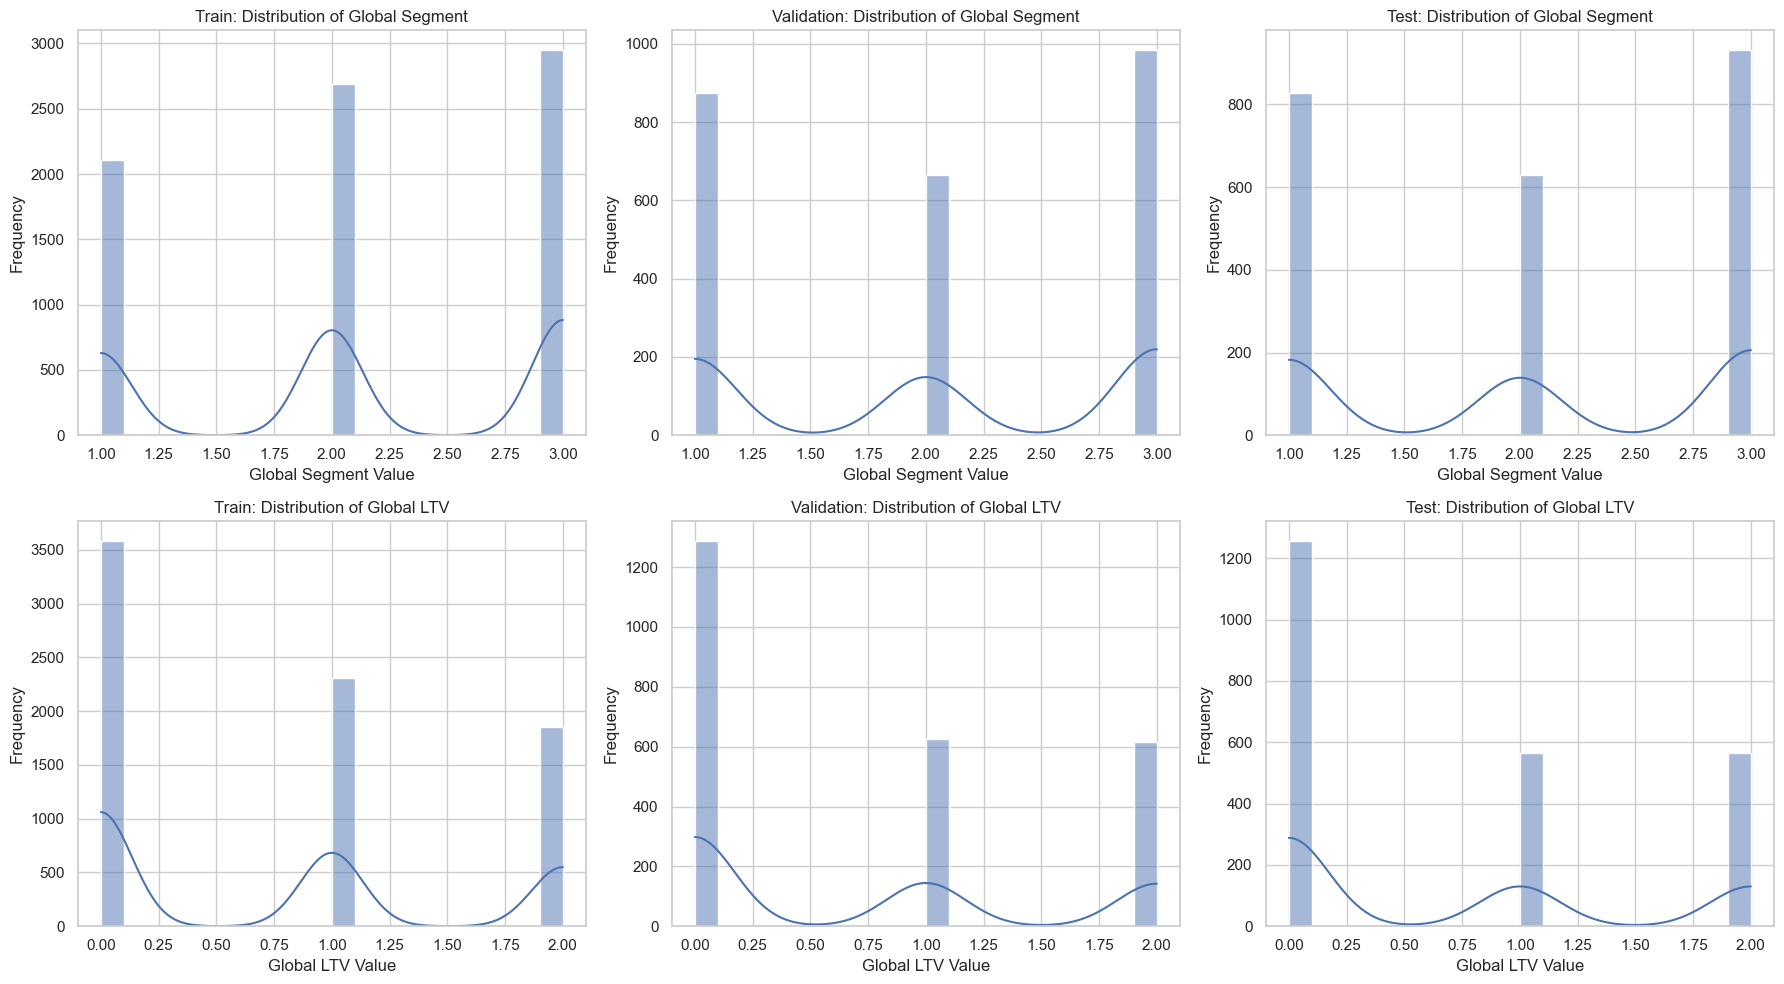

In [394]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns of subplots

# Train: global segment distribution
sns.histplot(sub_train_multi_arr['global_segment'], kde=True, bins=20, ax=axes[0, 0])
axes[0, 0].set_title('Train: Distribution of Global Segment')
axes[0, 0].set_xlabel('Global Segment Value')
axes[0, 0].set_ylabel('Frequency')

# Validation: global segment distribution
sns.histplot(sub_val_multi_arr['global_segment'], kde=True, bins=20, ax=axes[0, 1])
axes[0, 1].set_title('Validation: Distribution of Global Segment')
axes[0, 1].set_xlabel('Global Segment Value')
axes[0, 1].set_ylabel('Frequency')

# Test: global segment distribution
sns.histplot(sub_test_multi_arr['global_segment'], kde=True, bins=20, ax=axes[0, 2])
axes[0, 2].set_title('Test: Distribution of Global Segment')
axes[0, 2].set_xlabel('Global Segment Value')
axes[0, 2].set_ylabel('Frequency')

# Train: global LTV distribution
sns.histplot(sub_train_multi_arr['global_LTV'], kde=True, bins=20, ax=axes[1, 0])
axes[1, 0].set_title('Train: Distribution of Global LTV')
axes[1, 0].set_xlabel('Global LTV Value')
axes[1, 0].set_ylabel('Frequency')

# Validation: global LTV distribution
sns.histplot(sub_val_multi_arr['global_LTV'], kde=True, bins=20, ax=axes[1, 1])
axes[1, 1].set_title('Validation: Distribution of Global LTV')
axes[1, 1].set_xlabel('Global LTV Value')
axes[1, 1].set_ylabel('Frequency')

# Test: global LTV distribution
sns.histplot(sub_test_multi_arr['global_LTV'], kde=True, bins=20, ax=axes[1, 2])
axes[1, 2].set_title('Test: Distribution of Global LTV')
axes[1, 2].set_xlabel('Global LTV Value')
axes[1, 2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [395]:
sub_train_multi_arr.columns

Index(['Capstone_id', 'SUB_START', 'SUB_END', 'CURRENT_TERM', 'RESUBSCRIBER',
       'recency', 'frequency', 'monetary_1', 'recency_cluster',
       'frequency_cluster', 'monetary_cluster', 'segment', 'monetary_2',
       'multi_sub', 'churned', 'LTV_cluster', 'brands', 'num_brand',
       'global_segment', 'global_LTV'],
      dtype='object')

In [396]:
sub_train_multi_arr.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_train_multi_option3.csv')
sub_val_multi_arr.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_val_multi_option3.csv')
sub_test_multi_arr.to_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/sub_test_multi_option3.csv')